In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
import datetime


from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.seasonal as sm
from statsmodels.tsa.stattools import adfuller
import itertools
from pylab import rcParams


#import plotly for visualization
#import plotly.offline as pyoff

#import Keras
#import keras
#from keras.layers import Dense
#from keras.models import Sequential
#from keras.optimizers import Adam
#from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
#from keras.layers import LSTM

from sklearn.model_selection import KFold, cross_val_score, train_test_split

%matplotlib inline
#initiate plotly
#pyoff.init_notebook_mode()

In [2]:
#re-organize files into one file
bread_data_2014 = pd.read_csv('data/data_bread/2014-Table.csv')
bread_data_2015 = pd.read_csv('data/data_bread/2015-Table.csv')
bread_data_2016 = pd.read_csv('data/data_bread/2016-Table.csv')
bread_data_2017 = pd.read_csv('data/data_bread/2017-Table.csv')

In [3]:
weather_data_2014 = pd.read_csv("data/data_weather/en_climate_daily_ON_6104142_2014_P1D.csv")
weather_data_2015 = pd.read_csv("data/data_weather/en_climate_daily_ON_6104142_2015_P1D.csv")
weather_data_2016 = pd.read_csv("data/data_weather/en_climate_daily_ON_6104142_2016_P1D.csv")
weather_data_2017 = pd.read_csv("data/data_weather/en_climate_daily_ON_6104142_2017_P1D.csv")

In [4]:
bread_data = pd.DataFrame()
products = bread_data_2014['DESC_1'].unique()
bread_data_years = [bread_data_2014, bread_data_2015, bread_data_2016, bread_data_2017]

for years in bread_data_years:
    years = years.rename(columns={'DESC_1':'product_name', 'qty net' : 'quantity', 'Qty net':'quantity', 'DATE_DELIV':'date_billed', 'Date Facture': 'date_billed'})
    years = years.dropna(how='all', axis=1)
    bread_data = bread_data.append(years, ignore_index=True)

bread_data.date_billed = pd.to_datetime(bread_data.date_billed)

bread_data.info()
bread_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8048 entries, 0 to 8047
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   PRODUCT       8048 non-null   int64         
 1   product_name  8048 non-null   object        
 2   quantity      8048 non-null   int64         
 3   date_billed   8048 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 251.6+ KB


,PRODUCT,product_name,quantity,date_billed
0,50,Hamburger 8,372,2014-01-03
1,50,Hamburger 8,531,2014-01-04
2,50,Hamburger 8,443,2014-01-07
3,50,Hamburger 8,268,2014-01-08
4,50,Hamburger 8,423,2014-01-09
5,50,Hamburger 8,451,2014-01-10
6,50,Hamburger 8,683,2014-01-11
7,50,Hamburger 8,430,2014-01-14
8,50,Hamburger 8,247,2014-01-15
9,50,Hamburger 8,389,2014-01-16


   PRODUCT product_name  quantity date_billed
0       50  Hamburger 8       372  2014-01-03
1       50  Hamburger 8       531  2014-01-04
2       50  Hamburger 8       443  2014-01-07
3       50  Hamburger 8       268  2014-01-08
4       50  Hamburger 8       423  2014-01-09


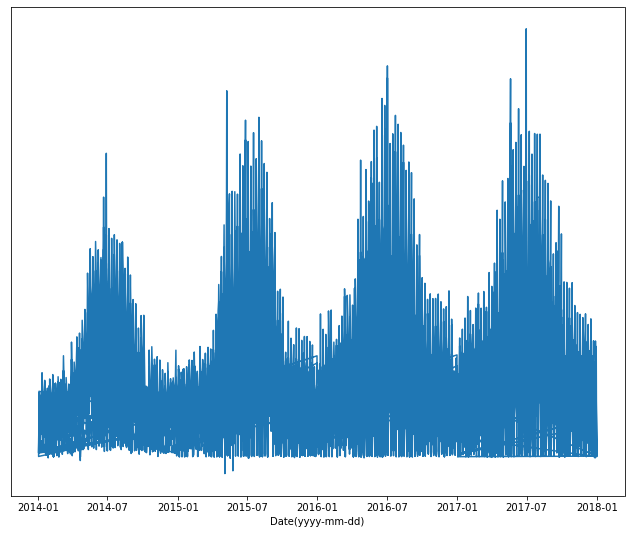

In [5]:
print(bread_data.head())

#viz sales per week per products
rcParams['figure.figsize'] = 11, 9
plt.plot(bread_data.date_billed, bread_data.quantity)
plt.xlabel('Date(yyyy-mm-dd)')
plt.ylabel('Bread Quantity')
plt.gca().axes.get_yaxis().set_visible(False)
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

In [6]:
weather_data = pd.DataFrame()
weather_data_years = [weather_data_2014, weather_data_2015, weather_data_2016, weather_data_2017]

for weather in weather_data_years:
    weather = weather.dropna(how='all', axis = 1)
    weather = weather.drop(['Year', 'Month', 'Day'], 1)
    weather_data = weather_data.append(weather, ignore_index=True)


weather_data['Date/Time'] = pd.DatetimeIndex(weather_data['Date/Time'], freq='D')

#experimenting with retrospected weather as the demand for bread may be based on future weather.
#weather_data['Date/Time'] = weather_data['Date/Time'] - datetime.timedelta(days=2)

print(weather_data.columns)
weather_data.head()

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time', 'Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)',
       'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag',
       'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)',
       'Cool Deg Days Flag', 'Total Rain Flag', 'Total Snow Flag',
       'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)',
       'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag'],
      dtype='object')


,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Total Rain Flag,Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-76.6,44.22,KINGSTON CLIMATE,6104142,2014-01-01,-12.2,NaN,-21.1,NaN,-16.7,...,M,M,0.2,NaN,10.0,NaN,4.0,NaN,39,NaN
1,-76.6,44.22,KINGSTON CLIMATE,6104142,2014-01-02,-21.0,NaN,-23.7,NaN,-22.4,...,M,M,0.9,NaN,22.0,NaN,4.0,NaN,52,NaN
2,-76.6,44.22,KINGSTON CLIMATE,6104142,2014-01-03,-17.1,NaN,-25.3,NaN,-21.2,...,M,M,0.0,NaN,9.0,NaN,2.0,NaN,39,NaN
3,-76.6,44.22,KINGSTON CLIMATE,6104142,2014-01-04,1.0,NaN,-21.9,NaN,-10.5,...,M,M,0.0,NaN,9.0,NaN,18.0,NaN,61,NaN
4,-76.6,44.22,KINGSTON CLIMATE,6104142,2014-01-05,4.0,NaN,-1.7,NaN,1.2,...,M,M,9.5,NaN,9.0,NaN,20.0,NaN,39,NaN


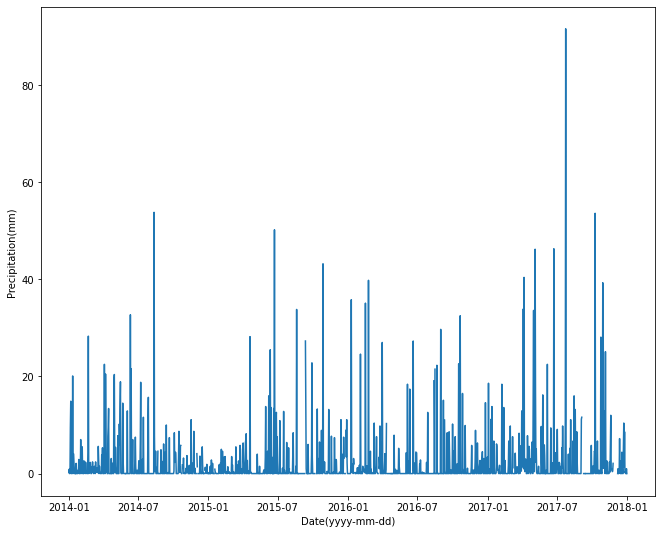

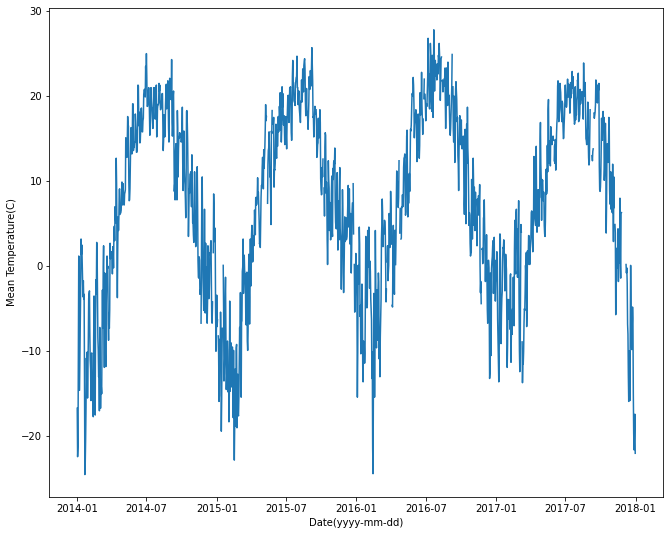

In [7]:
rcParams['figure.figsize'] = 11, 9
plt.plot(weather_data['Date/Time'], weather_data['Total Precip (mm)'])
plt.xlabel('Date(yyyy-mm-dd)')
plt.ylabel('Precipitation(mm)')
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

rcParams['figure.figsize'] = 11, 9
plt.plot(weather_data['Date/Time'], weather_data['Mean Temp (°C)'])
plt.xlabel('Date(yyyy-mm-dd)')
plt.ylabel('Mean Temperature(C)')
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

In [8]:
#merges two dataframe and removes the column used to merge on the second dataframe as to not repeat the information in
#   the returned dataframe
def merge_datasets(df1, df2, left_on, right_on):

    df = pd.merge(df1, df2, left_on=left_on, right_on=right_on)#change this for something that will only do it once

    if right_on in df.columns:
        df = df.drop([right_on], axis=1)

    return df

#bread_data.info()

In [9]:
#adds day name column to a dataframe, given the date column
def add_weekday_col(df, datetime):
    df['weekday'] = df[datetime].dt.day_name()

    return df

In [10]:
#prints correlation graph
def corr(df):
    plt.figure(figsize = (25,25))
    plt.rcParams.update({'font.size': 22})
    corr = df.corr()
    sn.heatmap(corr, annot=True)
    plt.show()

In [20]:
def adf_test(timeseries):
    print(('Results of Dickey-Fuller Test:'))
    adftest  = adfuller(timeseries, autolag='AIC')

    print(f'ADF Statistic: {adftest[0]}')
    print(f'p-value: {adftest[1]}')

    for key, value in adftest[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

    return float(adftest[1])

In [12]:
#adds missing dates to any datasets
def fill_missing_dates(df, prod_id, prod_name, fill = False):
    #Assumption: using this to look for first column that is a date, later will be use as index.
    dt = [column for column in df.columns if pd.api.types.is_datetime64_any_dtype(df[column])]
    datetime = df[dt].squeeze()

    #create empty dataframe with all dates missing from the user input dataframe.
    #r = pd.Series(index=pd.date_range(start=date(datetime.dt.year.min(), 1, 1), end=date(datetime.dt.year.max(), 12, 31), freq='D'))
    #deciding whether or not to include the missing dew days of the year

    r = pd.Series(index=pd.date_range(start=datetime.iloc[0], end=date(datetime.dt.year.max(), 12, 31), freq='D'))

    #merge the user input with empty dataframe so that all dates are present. The dates had to be index for this step to\
    # work hence the set_index and drop date_billed so that it is not duplicated
    df = pd.concat([df.set_index(datetime),r[~r.index.isin(df.set_index(datetime).index)]]).sort_index()

    #assign product name and id to new rows
    df['PRODUCT'] = prod_id
    df['product_name'] = prod_name

    print(df.isnull().sum())

    if fill:
        df = df.bfill().reset_index()

    else:
        df = df.reset_index()

    df = df.dropna(how='all', axis=1)

    print(df.isnull().sum())
    #has I need to use either ffill or bfill, the first or last day of the dataset will be nan as there is nothing to fill it.
    df = df[pd.notnull(df['quantity'])]

    df = df.drop('date_billed', 1).rename(columns={'index':'date_billed'})

    return df

#print(fill_missing_dates(bread_data, 50).tail())


In [13]:
#given a varaible in the dataframe, it will change the index of the dataframe
def set_index_sort(df, index_col):
    df[index_col] = pd.DatetimeIndex(df[index_col], freq = 'D')
    return df.set_index(index_col).sort_index()
    

In [14]:
#splits a dataset at a specific year.
def split_by_year(df, year):
    return df.loc[df.index.year < year], df.loc[df.index.year >= year]


In [15]:
#maybe be better to split at rounded week number
def train_test_split_timeseries(x, y, test_size=0.33):

    years_list = x.index.year.unique().to_list()

    split_index = int(np.ceil(len(years_list) * test_size))
    split_year = years_list[-split_index]

    X_train, X_test = split_by_year(x, split_year)
    y_train, y_test = split_by_year(y, split_year)

    return X_train, X_test, y_train, y_test

/Users/jeremiefraeys/anaconda3/envs/bread-ai_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


0               1459
PRODUCT            0
date_billed      275
product_name       0
quantity         275
dtype: int64
index           0
PRODUCT         0
date_billed     0
product_name    0
quantity        0
dtype: int64
Results of Dickey-Fuller Test:
ADF Statistic: -2.618507024784168
p-value: 0.08923224936126989
Critial Values:
   1%, -3.434908816804013
Critial Values:
   5%, -2.863553406963303
Critial Values:
   10%, -2.5678419239852994
0


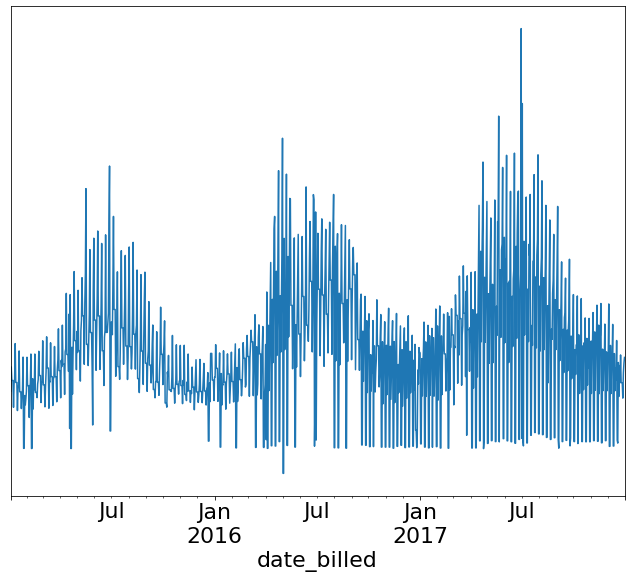

TypeError: float() argument must be a string or a number, not 'AxesSubplot'

In [32]:
##ARIMA modelling##

#change to True to see all plots
viz = True

for prod_id in bread_data.PRODUCT.unique():

    df = pd.DataFrame()

    df = bread_data.loc[bread_data.PRODUCT == prod_id]

    df = fill_missing_dates(df, prod_id, df.product_name.unique()[0], True)

    df = merge_datasets(df, weather_data, 'date_billed', 'Date/Time')
    
    df = add_weekday_col(df, 'date_billed')

    df = set_index_sort(df, 'date_billed')

    if adf_test(df['quantity']) > 0.05:
        #df['quantity'] = np.log(df['quantity'])
        df['quantity'] = df['quantity'] - df['quantity'].diff(periods=365)
        df['quantity'] = df['quantity'].dropna().plot()
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.show()

    print(df.quantity.isnull().sum())


    if viz:
        #as the seasonal chart is too frequent let's see one year or month
        rcParams['figure.figsize'] = 11, 9
        seas_d = sm.seasonal_decompose(df.quantity, model='additive')
        seas_d.plot()
        plt.show() #as the seasonal chart is too frequent let's see one year or month

        corr(df)

        adf_test(df.quantity)

    continue

    #split method will split at the year mark instead of percentage in as the data contains seasonality that would be lost otherewise.
    #X_train, X_test, y_train, y_test = train_test_split_timeseries(df.loc[:, df.columns != 'quantity'], df.quantity, test_size=0.25)
    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'quantity'], df.quantity, test_size=0.25)

    ##Models and forecasting##
    p = d = q = range(0,3)
    pdq = list(itertools.product(p,d,p))#get all combination of the tuple

    p2 = d2 = q2 = range(0,2)
    pdq2 = list(itertools.product(p2,d2,p2))
    s=365.25
    pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]#get all combination of the tuple

    combs = {}
    aics = []

    for comb in pdq:
        for season_comb in pdqs2:
                model = SARIMAX(y_train, order=comb, exog=[X_train['Mean Temp (°C)'], X_train['Total Precip (mm)']], seasonal_order=season_comb, enforce_stationarity=False, enforce_invertibility=False)
                model = model.fit()
                aic = int(model.aic)
                combs.update({aic : [comb, season_comb]})
                aics.append(aic)

                print(comb, " : ", season_comb, "-->", model.aic)

    best_aic = min(aics)

    model = SARIMAX(y_train, order=combs[best_aic][0], seasonal_order=combs[best_aic][1])
    model_fit = model.fit()
    
    print(model_fit.summary())

    period = 365
    y_hat = model_fit.forecast(period)

    error = mean_squared_error(y_test[:period], y_hat)
    print('test MSE: %.3f' % error)

In [15]:
##LSTM modelling ##


df = pd.DataFrame()

df = fill_missing_dates(df, prod_id, df.product_name.unique()[0], True)

df = merge_datasets(df, weather_data, 'date_billed', 'Date/Time')

df = add_weekday_col(df, 'date_billed')

df = set_index_sort(df, 'date_billed')




NameError: name 'fill_missing_dates' is not defined